### Dataset - [SpamAssassin Public Corpus ](https://www.kaggle.com/datasets/beatoa/spamassassin-public-corpus) from kaggle.

### Project - Email Spam Classification Model

### Summary:
In this project, I built a machine learning model with 97% accuracy to classify emails as spam or ham (non-spam) using text classification techniques. The project involved several steps, including data preprocessing, feature extraction, model training, and evaluation. The primary goal was to develop a reliable model that could accurately identify spam emails while maintaining high precision and recall.




# 1. Loading & Cleaning the data

In [1]:
import os
from bs4 import BeautifulSoup
import email
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from email import policy
from email.parser import BytesParser
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import re


In [2]:
# defining paths
dataset_path = 'data'
hard_ham_path = os.path.join(dataset_path, "hard_ham")
easy_ham_path = os.path.join(dataset_path, "easy_ham")
spam_path = os.path.join(dataset_path, "spam_2")

## 1.1. Parsing the email
Parsing email means separating different parts of email for easy access.
1. Raw Email
2. Date
3. From
4. to
5. Body of the Email

In [3]:
class ParsedEmail:
    def __init__(self, raw_email, label = None):
        self.raw_email = raw_email
        self.email_message = None
        self.Date = None
        self.From = None
        self.To = None
        self.Subject = None
        self.Body = None
        self.Label = label
        self._parse_email()

    def _parse_email(self):
        # Parse the email message
        self.email_message = email.message_from_string(self.raw_email)

        # Extract headers
        self.Date = self.email_message.get('Date')
        self.From = self.email_message.get('From')
        self.To = self.email_message.get('To')
        self.Subject = self.email_message.get('Subject')

        # Extract and clean the body
        self.Body = self._get_clean_body()

    def _get_clean_body(self):
        body = ""

        # If the message is multipart, we need to extract the actual body part
        if self.email_message.is_multipart():
            for part in self.email_message.walk():
                # Try to extract plain text first
                if part.get_content_type() == 'text/plain':
                    body = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                    break
                # If HTML content is found, clean it up
                elif part.get_content_type() == 'text/html':
                    html_content = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                    body = self._clean_html(html_content)
                    break
        else:
            # Handle single-part emails
            if self.email_message.get_content_type() == 'text/plain':
                body = self.email_message.get_payload(decode=True).decode('utf-8', errors='ignore')
            elif self.email_message.get_content_type() == 'text/html':
                html_content = self.email_message.get_payload(decode=True).decode('utf-8', errors='ignore')
                body = self._clean_html(html_content)

        # Clean the body (apply the same cleaning process from earlier)
        body = re.sub(r'^\s*>.*$', '', body, flags=re.MULTILINE)  # Remove quoted text
        body = re.sub(r'https?://\S+', '', body)  # Remove URLs
        body = re.split(r'\n--\n', body)[0]  # Remove signature block
        body = re.sub(r'\s+', ' ', body).strip()  # Normalize whitespace
        return body

    @staticmethod
    def _clean_html(html_content):
        """Removes HTML tags from content using BeautifulSoup"""
        soup = BeautifulSoup(html_content, 'html.parser')
        return soup.get_text(separator=' ') 

In [4]:
def read_emails_from_folder(folder_path, label):
    emails = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            try:
                raw_email = file.read().decode('utf-8', errors='ignore')
                parsed_email = ParsedEmail(raw_email, label)
                emails.append(parsed_email)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return emails

In [5]:
test_email = read_emails_from_folder('data/test', label = 0)

In [6]:
print(f"""
Email Details:
---------------
Label: {test_email[0].Label}
Date: {test_email[0].Date}
From: {test_email[0].From}
To: {test_email[0].To}
Subject: {test_email[0].Subject}

Body:
{test_email[0].Body}
""")



Email Details:
---------------
Label: 0
Date: Fri, 02 Aug 2002 23:37:59 0530
From: "Start Now" <startnow2002@hotmail.com>
To: ilug@linux.ie
Subject: [ILUG] STOP THE MLM INSANITY

Body:
Greetings! You are receiving this letter because you have expressed an interest in receiving information about online business opportunities. If this is erroneous then please accept my most sincere apology. This is a one-time mailing, so no removal is necessary. If you've been burned, betrayed, and back-stabbed by multi-level marketing, MLM, then please read this letter. It could be the most important one that has ever landed in your Inbox. MULTI-LEVEL MARKETING IS A HUGE MISTAKE FOR MOST PEOPLE MLM has failed to deliver on its promises for the past 50 years. The pursuit of the "MLM Dream" has cost hundreds of thousands of people their friends, their fortunes and their sacred honor. The fact is that MLM is fatally flawed, meaning that it CANNOT work for most people. The companies and the few who earn th

## 1.2. Labeling:
labeling the emails with their category
- spam ==> 1
- ham ==> 0

In [7]:
hard_ham_emails = read_emails_from_folder(hard_ham_path, label = 0)
easy_ham_emails = read_emails_from_folder(easy_ham_path, label = 0)
spam_emails = read_emails_from_folder(spam_path, label = 1)

In [8]:
print(spam_emails[1].Body)

The Need For Safety Is Real In 2002, You Might Only Get One Chance - Be Ready! Free Shipping & Handling Within The (USA) If You Order Before May 25, 2002! 3 Day Super Sale, Now Until May 7, 2002! Save Up To $30.00 On Some Items! IT'S GETTING TO BE SPRING AGAIN, PROTECT YOURSELF AS YOU WALK, JOG AND EXERCISE OUTSIDE. ALSO PROTECT YOUR LOVED ONES AS THEY RETURN HOME FROM COLLEGE! * LEGAL PROTECTION FOR COLLEGE STUDENTS! * GREAT UP'COMING OUTDOOR PROTECTION GIFTS! * THERE IS NOTHING WORTH MORE PROTECTING THAN LIFE! * OUR STUN DEVICES & PEPPER PRODUCTS ARE LEGAL PROTECTION! JOIN THE WAR ON CRIME! STUN GUNS AND BATONS EFFECTIVE - SAFE - NONLETHAL PROTECT YOUR LOVED ONES AND YOURSELF No matter who you are, no matter what City or Town you live in, if you live in America, you will be touched by crime. You hear about it on TV. You read about it in the newspaper. It's no secret that crime is a major problem in the U.S. today. Criminals are finding it easier to commit crimes all the time. Weapons

In [9]:
# Combine all emails and labels (easy_ham, hard_ham, spam)
emails = easy_ham_emails + hard_ham_emails + spam_emails

bodies = [email.Body for email in emails]
labels = [email.Label for email in emails]


# 2. Preprocessing the training data

Before we train the data... we need to perform some preprocessing to the training data, which includes:
- Lowercasing
- Remove stop words (like: and, the, is etc)
- Tokenization
- Stemming (i.e - running --> run)
- Remove punctuations

In [10]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [11]:
stemmer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

def preprocess_email_body(body, l=stemmer, stop_words=stopwords):
    # 1. Lowercasing
    body = body.lower()

    # 2. Remove punctuation
    body = re.sub(r'[^\w\s]', '', body)

    # 3. Tokenization
    tokens = word_tokenize(body)

    # 4. Remove stop words and perform stemming
    processed_tokens = [l.lemmatize(word) for word in tokens if word not in stop_words]

    # Join tokens back into a string
    output = ' '.join(processed_tokens)
    return output

In [12]:
# applying preprocessing to the bodies
processed_email_bodies = list(map(preprocess_email_body, bodies))

In [13]:
print(processed_email_bodies[2])

man threatens explosion moscow thursday august 22 2002 140 pm moscow ap security officer thursday seized unidentified man said armed explosive threatened blow truck front russia federal security service headquarters moscow ntv television reported officer seized automatic rifle man carrying man got truck taken custody ntv said detail immediately available man demanded talk high government official interfax itartass news agency said ekho moskvy radio reported wanted talk russian president vladimir putin police security force rushed security service building within block kremlin red square bolshoi ballet surrounded man claimed one half ton explosive news agency said negotiation continued one half hour outside building itartass interfax reported citing witness man later drove away building police escort drove street near moscow olympic penta hotel authority held negotiation moscow police press service said move appeared attempt security service get secure location yahoo group sponsor 4 dvd

## 2.1. Vectorization:
vectorization is the process of converting text or data into a numerical format that machine learning models can understand. In the context of natural language processing (NLP), it refers to transforming words, sentences, or documents into numerical vectors.

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(processed_email_bodies).toarray()
y = np.array(labels)

print(f"{X.shape = }")
print(f"{y.shape = }")

X.shape = (4198, 5000)
y.shape = (4198,)


# 3. Training the Model

In [15]:
print(f"{len(easy_ham_emails) = }")
print(f"{len(hard_ham_emails) = }")
print(f"{len(spam_emails) = }")

len(easy_ham_emails) = 2551
len(hard_ham_emails) = 250
len(spam_emails) = 1397


The training data is imbalanced
- ham = 2801
- spam = 1397

To fix this issue we can oversample the minority (spam) class using SMOTE (Synthetic Minority Over-sampling Technique). 

## 3.1. Oversampling through SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to oversample the minority class (spam)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set size: {len(X_train)}")
print(f"Resampled training set size: {len(X_train_resampled)}")

Original training set size: 2938
Resampled training set size: 3888


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Train the model
model = MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed performance report
print(classification_report(y_test, y_pred))


Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       857
           1       0.96      0.96      0.96       403

    accuracy                           0.97      1260
   macro avg       0.97      0.97      0.97      1260
weighted avg       0.97      0.97      0.97      1260



# 4. Evaluation - Confusion Matrix

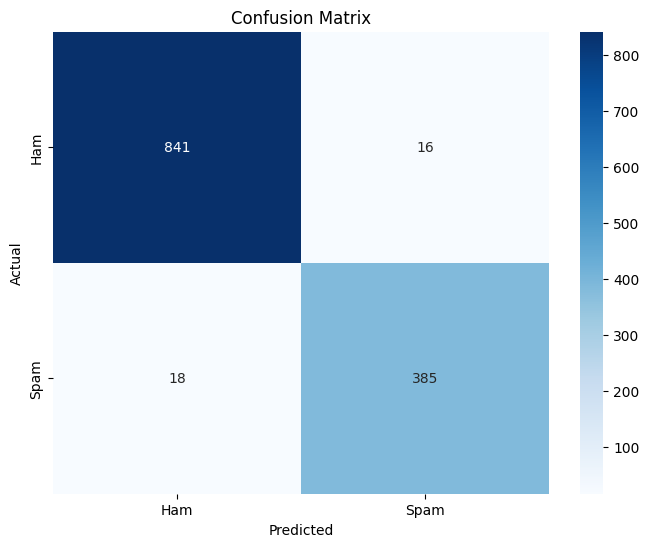

In [20]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
